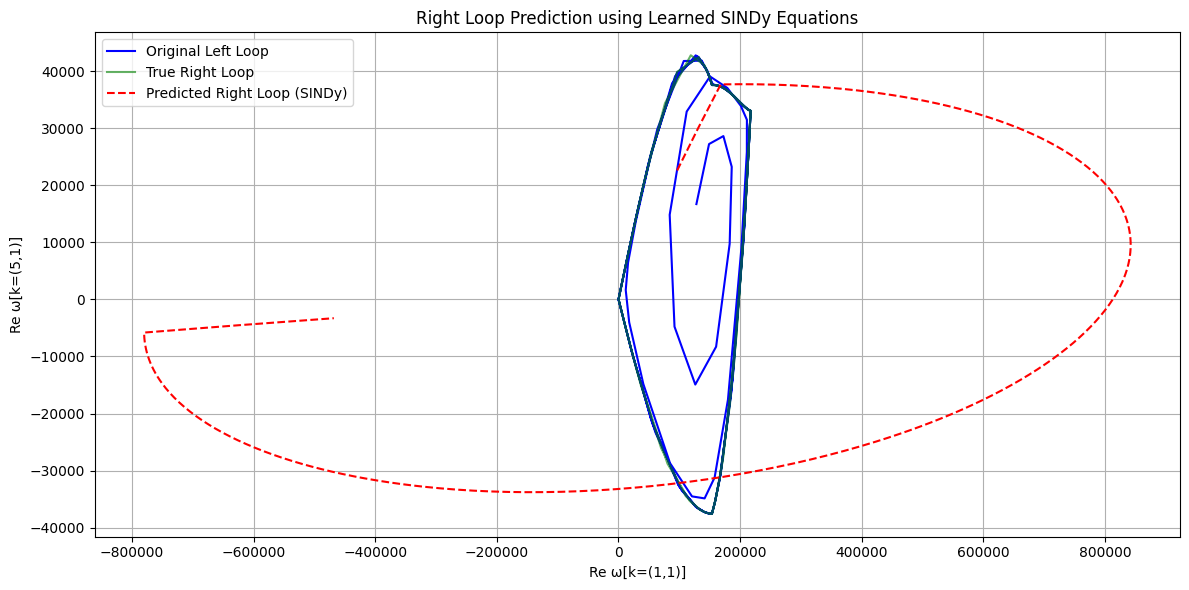

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.integrate import solve_ivp

# Load data
data = np.loadtxt(r"C:\Users\lenovo\Downloads\projection.dat")[:10000]
LOOP_LENGTH = 500

# Normalize
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Extract left-right loop pairs
X, Y = [], []
for i in range(len(data_scaled) // (2 * LOOP_LENGTH)):
    start = i * 2 * LOOP_LENGTH
    left = data_scaled[start : start + LOOP_LENGTH]
    right = data_scaled[start + LOOP_LENGTH : start + 2 * LOOP_LENGTH]
    if len(left) == LOOP_LENGTH and len(right) == LOOP_LENGTH:
        X.append(left)
        Y.append(right)
X = np.array(X)
Y = np.array(Y)

# Pick one pair for testing
idx = 0
left_loop = X[idx]
true_right_loop = Y[idx]

# === Learned dynamics from SINDy ===
def sindy_rhs(t, x):
    x0, x1 = x
    dx0 = -0.002 * x0 + 0.044 * x1
    dx1 = -0.002 * x0 + 0.002 * x1
    return [dx0, dx1]

# Simulate forward from last point of left loop
x_init = left_loop[-1]
t_span = (0, LOOP_LENGTH)  # simulate over 500 steps
t_eval = np.arange(LOOP_LENGTH)

sol = solve_ivp(sindy_rhs, t_span, x_init, t_eval=t_eval, method='RK45')
pred_right_loop = sol.y.T  # shape (500, 2)

# Inverse transform to original scale
left_orig = scaler.inverse_transform(left_loop)
true_right_orig = scaler.inverse_transform(true_right_loop)
pred_right_orig = scaler.inverse_transform(pred_right_loop)

# Optional smoothing
def smooth(x, w=5):
    return np.convolve(x, np.ones(w)/w, mode='same')

pred_right_orig[:, 0] = smooth(pred_right_orig[:, 0])
pred_right_orig[:, 1] = smooth(pred_right_orig[:, 1])

# Plot
plt.figure(figsize=(12,6))
plt.plot(left_orig[:, 0], left_orig[:, 1], label='Original Left Loop', color='blue')
plt.plot(true_right_orig[:, 0], true_right_orig[:, 1], label='True Right Loop', color='green', alpha=0.6)
plt.plot(pred_right_orig[:, 0], pred_right_orig[:, 1], label='Predicted Right Loop (SINDy)', color='red', linestyle='--')
plt.title("Right Loop Prediction using Learned SINDy Equations")
plt.xlabel("Re ω[k=(1,1)]")
plt.ylabel("Re ω[k=(5,1)]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pysindy as ps

# Load data
data = np.loadtxt(r"C:\Users\lenovo\Downloads\projection.dat")[:10000]
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Loop extraction
LOOP_LENGTH = 500
start = 0
left_loop = data_scaled[start : start + LOOP_LENGTH]
right_loop = data_scaled[start + LOOP_LENGTH : start + 2 * LOOP_LENGTH]

# Assume this is your LSTM output instead of using real LSTM now
lstm_pred_right = right_loop.copy()  # Replace this with actual LSTM output in practice

# Fit SINDy on LSTM prediction
dt = 1.0
diff_method = ps.SmoothedFiniteDifference()
library = ps.PolynomialLibrary(degree=5)
optimizer = ps.STLSQ(threshold=1e-5, alpha=1e-6)

model = ps.SINDy(optimizer=optimizer, feature_library=library, differentiation_method=diff_method)
model.fit(lstm_pred_right, t=dt)
model.print()

# Simulate right loop forward using last point of left loop
t_sim = np.arange(0, LOOP_LENGTH)
predicted_right = model.simulate(left_loop[-1], t_sim)

# Inverse scale
left_orig = scaler.inverse_transform(left_loop)
true_right_orig = scaler.inverse_transform(right_loop)
pred_right_orig = scaler.inverse_transform(predicted_right)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(left_orig[:, 0], left_orig[:, 1], label='Original Left Loop', color='blue')
plt.plot(true_right_orig[:, 0], true_right_orig[:, 1], label='True Right Loop', color='green')
plt.plot(pred_right_orig[:, 0], pred_right_orig[:, 1], label='Predicted Right Loop (Hybrid)', color='red', linestyle='--')
plt.title("Right Loop Prediction using Hybrid (LSTM + SINDy)")
plt.xlabel("Re ω[k=(1,1)]")
plt.ylabel("Re ω[k=(5,1)]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


(x0)' = -0.438 1 + -3.739 x0 + 0.719 x1 + -6.626 x0^2 + 1.391 x0 x1 + 2.000 x1^2 + -0.074 x0^3 + 19.363 x0^2 x1 + -1.920 x0 x1^2 + -1.496 x1^3 + 18.829 x0^4 + -34.684 x0^3 x1 + 9.624 x0^2 x1^2 + -5.695 x0 x1^3 + 0.533 x1^4 + -9.480 x0^5 + 13.034 x0^4 x1 + -6.882 x0^3 x1^2 + 6.409 x0^2 x1^3 + -1.531 x0 x1^4 + 0.552 x1^5
(x1)' = -2.287 1 + -21.530 x0 + 2.895 x1 + -25.859 x0^2 + 18.021 x0 x1 + 11.522 x1^2 + 100.597 x0^3 + 42.398 x0^2 x1 + -9.836 x0 x1^2 + -11.982 x1^3 + -56.991 x0^4 + -117.570 x0^3 x1 + 11.382 x0^2 x1^2 + -6.074 x0 x1^3 + 1.747 x1^4 + 3.833 x0^5 + 55.888 x0^4 x1 + -7.970 x0^3 x1^2 + 13.856 x0^2 x1^3 + -4.285 x0 x1^4 + 2.203 x1^5


C:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_base.py:290: RuntimeWarning: overflow encountered in matmul
  return X @ coef_.T + self.intercept_


ValueError: Input contains infinity or a value too large for dtype('float64').

In [3]:
import numpy as np
import pysindy as ps
from sklearn.preprocessing import StandardScaler

# Load the data
data = np.loadtxt(r"C:\Users\lenovo\Downloads\projection.dat")[:10000]  # (10000, 2)
dt = 1.0  # Time step

# Normalize the data (critical for SINDy to detect correct terms)
scaler = StandardScaler(with_mean=True, with_std=True)
data_normalized = scaler.fit_transform(data)

# Compute derivatives using Smoothed Finite Difference
diff_method = ps.SmoothedFiniteDifference(
    smoother_kws={'window_length': 5},  # Adjust for smoother derivatives
)

# Use a higher-degree polynomial library to capture nonlinearities
feature_library = ps.PolynomialLibrary(
    degree=5,  # Increased from 2 to capture more complex dynamics
    include_interaction=True,
    include_bias=False,
)

# Optimizer with reduced threshold to retain more terms
optimizer = ps.SR3(
    threshold=1e-5,  # More sensitive to small coefficients
    nu=1.0,          # Regularization strength
    max_iter=1000,   # Ensure convergence
)

# Define and fit the SINDy model
model = ps.SINDy(
    optimizer=optimizer,
    feature_library=feature_library,
    differentiation_method=diff_method,
)

# Fit the model to normalized data
model.fit(data_normalized, t=dt)

# Print the discovered equations
model.print()

# (Optional) Simulate the model and compare to original data
x_sim = model.simulate(data_normalized[0], t=len(data_normalized), integrator_kws={'rtol': 1e-12})
x_sim_original_scale = scaler.inverse_transform(x_sim)  # Rescale back to original units

(x0)' = -0.096 x0 + 0.290 x1 + -0.018 x0^2 + -0.117 x0 x1 + -0.049 x1^2 + 0.016 x0^3 + -0.277 x0^2 x1 + -0.251 x0 x1^2 + -0.089 x1^3 + 0.017 x0^4 + 0.069 x0^3 x1 + 0.023 x0^2 x1^2 + 0.033 x0 x1^3 + 0.033 x1^4 + 0.009 x0^5 + 0.087 x0^4 x1 + 0.040 x0^3 x1^2 + 0.011 x0^2 x1^3 + 0.183 x0 x1^4 + 0.017 x1^5
(x1)' = -0.039 x0 + 0.015 x1 + -0.614 x0^2 + 0.046 x0 x1 + 0.311 x1^2 + -0.685 x0^3 + -0.088 x0^2 x1 + 0.554 x0 x1^2 + 0.173 x1^3 + 0.365 x0^4 + -0.018 x0^3 x1 + -0.043 x0^2 x1^2 + -0.012 x0 x1^3 + -0.126 x1^4 + 0.312 x0^5 + -0.011 x0^4 x1 + -0.062 x0^3 x1^2 + 0.070 x0^2 x1^3 + -0.140 x0 x1^4 + -0.130 x1^5


ValueError: For continuous time model, t must be an array of time points at which to simulate

(x0)' = -0.096 x0 + 0.290 x1 + -0.018 x0^2 + -0.117 x0 x1 + -0.049 x1^2 + 0.016 x0^3 + -0.277 x0^2 x1 + -0.251 x0 x1^2 + -0.089 x1^3 + 0.017 x0^4 + 0.069 x0^3 x1 + 0.023 x0^2 x1^2 + 0.033 x0 x1^3 + 0.033 x1^4 + 0.009 x0^5 + 0.087 x0^4 x1 + 0.040 x0^3 x1^2 + 0.011 x0^2 x1^3 + 0.183 x0 x1^4 + 0.017 x1^5
(x1)' = -0.039 x0 + 0.015 x1 + -0.614 x0^2 + 0.046 x0 x1 + 0.311 x1^2 + -0.685 x0^3 + -0.088 x0^2 x1 + 0.554 x0 x1^2 + 0.173 x1^3 + 0.365 x0^4 + -0.018 x0^3 x1 + -0.043 x0^2 x1^2 + -0.012 x0 x1^3 + -0.126 x1^4 + 0.312 x0^5 + -0.011 x0^4 x1 + -0.062 x0^3 x1^2 + 0.070 x0^2 x1^3 + -0.140 x0 x1^4 + -0.130 x1^5


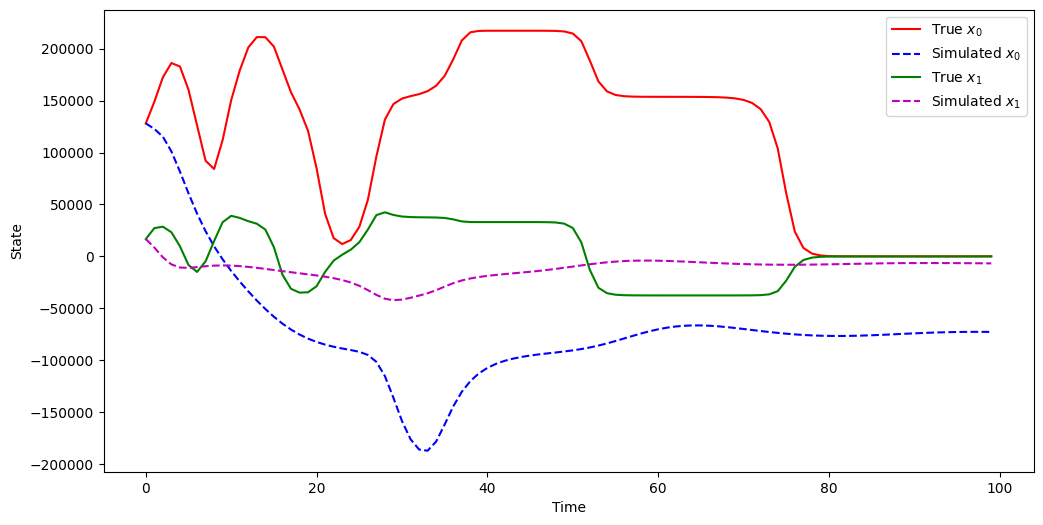

In [4]:
import numpy as np
import pysindy as ps
from sklearn.preprocessing import StandardScaler

# Load the data
data = np.loadtxt(r"C:\Users\lenovo\Downloads\projection.dat")[:10000]  # (10000, 2)
dt = 1.0  # Time step

# Normalize the data
scaler = StandardScaler(with_mean=True, with_std=True)
data_normalized = scaler.fit_transform(data)

# Compute derivatives
diff_method = ps.SmoothedFiniteDifference(
    smoother_kws={'window_length': 5},
)

# Feature library
feature_library = ps.PolynomialLibrary(
    degree=5,
    include_interaction=True,
    include_bias=False,
)

# Optimizer
optimizer = ps.SR3(
    threshold=1e-5,
    nu=1.0,
    max_iter=1000,
)

# Define and fit the model
model = ps.SINDy(
    optimizer=optimizer,
    feature_library=feature_library,
    differentiation_method=diff_method,
)
model.fit(data_normalized, t=dt)

# Print discovered equations
model.print()

# Simulate the model (FIXED: Use time array instead of integer)
t_sim = np.arange(len(data_normalized)) * dt  # Time points [0, dt, 2*dt, ...]
x_sim = model.simulate(
    data_normalized[0], 
    t=t_sim,  # Pass time array, not integer
    integrator_kws={'rtol': 1e-12}
)

# Rescale back to original units
x_sim_original_scale = scaler.inverse_transform(x_sim)

# Compare with true data (first 100 steps for visualization)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(t_sim[:100], data[:100, 0], 'r-', label='True $x_0$')
plt.plot(t_sim[:100], x_sim_original_scale[:100, 0], 'b--', label='Simulated $x_0$')
plt.plot(t_sim[:100], data[:100, 1], 'g-', label='True $x_1$')
plt.plot(t_sim[:100], x_sim_original_scale[:100, 1], 'm--', label='Simulated $x_1$')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.show()

(x0)' = -0.003 1 + -0.066 x0 + 0.156 x1 + 0.005 x0^2 + -0.009 x0 x1 + -0.006 x1^2 + 0.012 x0^3 + -0.036 x0^2 x1 + 0.039 x0 x1^2 + -0.075 x1^3
(x1)' = -0.015 1 + -0.117 x0 + 0.033 x1 + -0.007 x0^2 + 0.011 x0 x1 + 0.015 x1^2 + 0.003 x0^3 + -0.002 x0^2 x1 + 0.079 x0 x1^2 + -0.018 x1^3


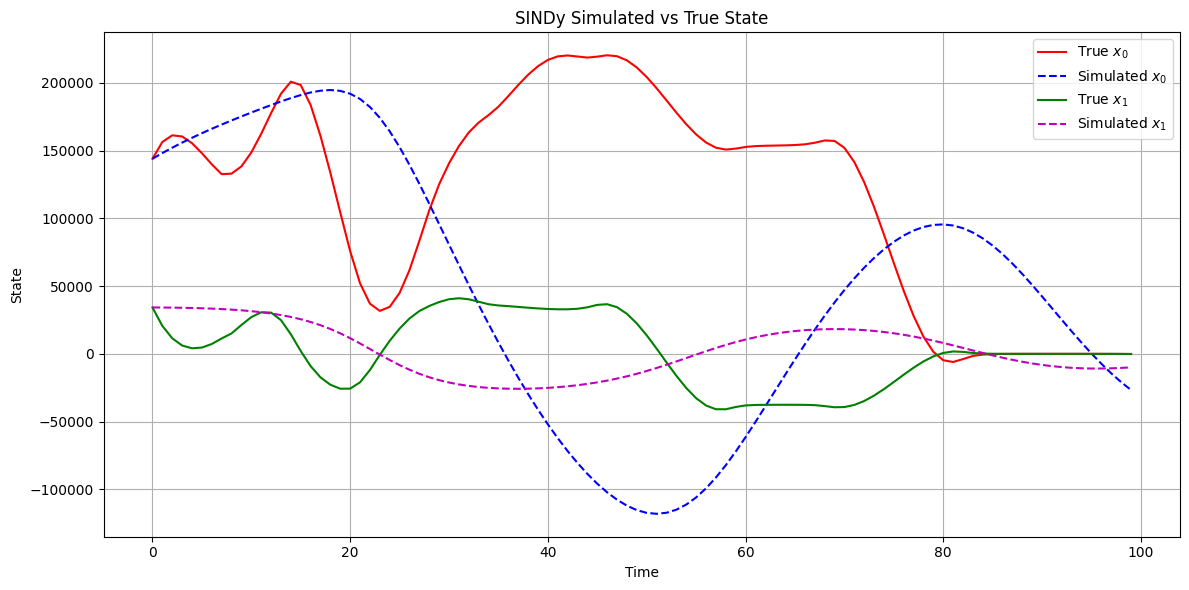

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
import pysindy as ps

# === Load and smooth the data ===
data = np.loadtxt(r"C:\Users\lenovo\Downloads\projection.dat")[:10000]
data[:, 0] = savgol_filter(data[:, 0], window_length=15, polyorder=3)
data[:, 1] = savgol_filter(data[:, 1], window_length=15, polyorder=3)

# === Normalize the data ===
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# === Time step ===
dt = 1.0
t = np.arange(len(data_scaled)) * dt

# === Differentiation method ===
diff_method = ps.SmoothedFiniteDifference()

# === Polynomial feature library (simplified) ===
feature_library = ps.PolynomialLibrary(degree=3)

# === Optimizer (adjusted threshold and alpha) ===
optimizer = ps.STLSQ(threshold=1e-3, alpha=1e-6)

# === Build and fit the model ===
model = ps.SINDy(
    optimizer=optimizer,
    feature_library=feature_library,
    differentiation_method=diff_method
)
model.fit(data_scaled, t=dt)

# === Print learned equations ===
model.print()

# === Simulate the dynamics ===
x0 = data_scaled[0]  # Initial condition
x_sim = model.simulate(x0, t)

# === Transform back to original scale ===
x_sim_original = scaler.inverse_transform(x_sim)

# === Plot the results ===
plt.figure(figsize=(12, 6))
plt.plot(t[:100], data[:100, 0], 'r-', label='True $x_0$')
plt.plot(t[:100], x_sim_original[:100, 0], 'b--', label='Simulated $x_0$')
plt.plot(t[:100], data[:100, 1], 'g-', label='True $x_1$')
plt.plot(t[:100], x_sim_original[:100, 1], 'm--', label='Simulated $x_1$')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.grid(True)
plt.title("SINDy Simulated vs True State")
plt.tight_layout()
plt.show()


Training BiLSTM...
Epoch 0, Loss = 1.004593
Epoch 50, Loss = 0.210080
Epoch 100, Loss = 0.003610
Epoch 150, Loss = 0.002663
Epoch 200, Loss = 0.002303

Learned SINDy Equations:
(x0)' = 0.033 1 + 0.064 x0 + 0.283 x1 + -0.053 x0^2 + -0.130 x0 x1 + -0.107 x1^2 + -0.051 x0^3 + -0.228 x0^2 x1 + -0.447 x0 x1^2 + -0.171 x1^3 + 0.007 x0^4 + 0.064 x0^3 x1 + 0.075 x0^2 x1^2 + 0.055 x0 x1^3 + 0.052 x1^4 + 0.001 x0^5 + 0.067 x0^4 x1 + 0.116 x0^3 x1^2 + 0.029 x0^2 x1^3 + 0.228 x0 x1^4 + 0.052 x1^5
(x1)' = 0.214 1 + 0.852 x0 + 0.160 x1 + -0.830 x0^2 + -0.083 x0 x1 + -0.166 x1^2 + -1.120 x0^3 + -0.022 x0^2 x1 + -0.739 x0 x1^2 + -0.245 x1^3 + 0.357 x0^4 + 0.224 x0^2 x1^2 + 0.111 x0 x1^3 + 0.065 x1^4 + 0.324 x0^5 + -0.044 x0^4 x1 + 0.320 x0^3 x1^2 + 0.136 x0^2 x1^3 + 0.285 x0 x1^4 + 0.042 x1^5


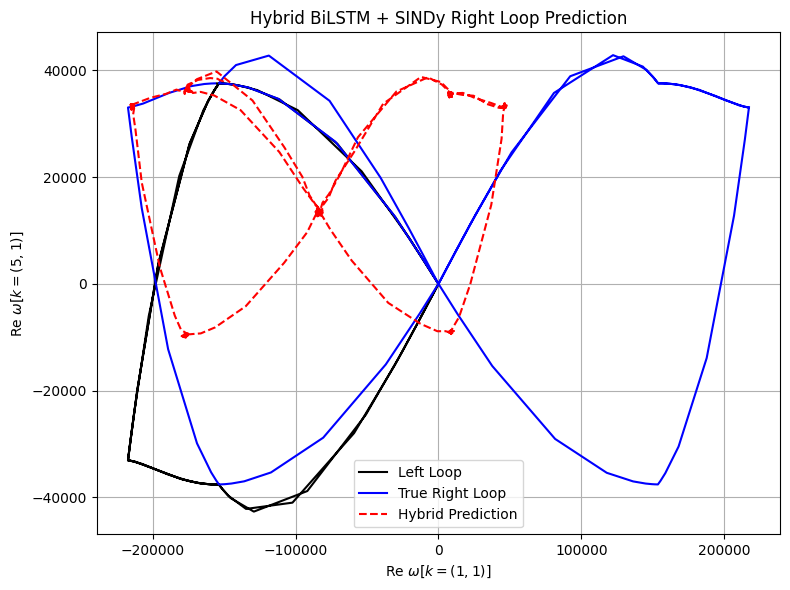

In [7]:
# Hybrid BiLSTM + PySINDy Model to Predict Right Loop from Left Loop

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import pysindy as ps

# ================================================
# 1. Load and Normalize Data
# ================================================
data = np.loadtxt(r"C:\Users\lenovo\Downloads\projection.dat")[:10000]  # (10000, 2)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# ================================================
# 2. Extract Loop Pairs
# ================================================
LOOP_LEN = 500
NUM_LOOPS = len(data_scaled) // (2 * LOOP_LEN)
X_loops, Y_loops = [], []

for i in range(NUM_LOOPS):
    start = i * 2 * LOOP_LEN
    left = data_scaled[start : start + LOOP_LEN]
    right = data_scaled[start + LOOP_LEN : start + 2 * LOOP_LEN]
    X_loops.append(left)
    Y_loops.append(right)

X = np.array(X_loops)
Y = np.array(Y_loops)

# ================================================
# 3. Train-Test Split
# ================================================
split = int(0.85 * len(X))
X_train, Y_train = torch.FloatTensor(X[:split]), torch.FloatTensor(Y[:split])
X_test, Y_test = torch.FloatTensor(X[split:]), torch.FloatTensor(Y[split:])
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=16, shuffle=True)

# ================================================
# 4. Train BiLSTM Model
# ================================================
class BiLSTM(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, loop_len=LOOP_LEN):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers=2, bidirectional=True, batch_first=True)
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size * 2, 128),
            nn.ReLU(),
            nn.Linear(128, loop_len * input_size)
        )
        self.loop_len = loop_len
        self.input_size = input_size

    def forward(self, x):
        _, (h, _) = self.encoder(x)
        z = torch.cat([h[-2], h[-1]], dim=1)
        out = self.decoder(z)
        return out.view(-1, self.loop_len, self.input_size)

model = BiLSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

print("Training BiLSTM...")
for epoch in range(250):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss = {total_loss / len(train_loader):.6f}")

# ================================================
# 5. Use PySINDy to Extract Equations
# ================================================
diff = ps.SmoothedFiniteDifference()
lib = ps.PolynomialLibrary(degree=5)
opt = ps.STLSQ(threshold=1e-3, alpha=1e-6)
sindy_model = ps.SINDy(optimizer=opt, differentiation_method=diff, feature_library=lib)
sindy_model.fit(data_scaled, t=1.0)
print("\nLearned SINDy Equations:")
sindy_model.print()

# ================================================
# 6. Hybrid Prediction
# ================================================
model.eval()
idx = 0  # First test loop
left_test = X_test[idx].unsqueeze(0)
pred_lstm = model(left_test).squeeze(0).detach().numpy()

# Simulate from last left point using SINDy
t_sim = np.arange(LOOP_LEN)
init_state = left_test[0, -1].numpy()
pred_sindy = sindy_model.simulate(init_state, t_sim)

# Combine: average or blend (simple average here)
pred_hybrid = 0.6 * pred_lstm + 0.4 * pred_sindy

# Inverse transform to original scale
left_orig = scaler.inverse_transform(left_test.squeeze(0).numpy())
pred_orig = scaler.inverse_transform(pred_hybrid)
true_orig = scaler.inverse_transform(Y_test[idx].numpy())

# ================================================
# 7. Plot Comparison
# ================================================
plt.figure(figsize=(8,6))
plt.plot(left_orig[:,0], left_orig[:,1], 'k-', label='Left Loop')
plt.plot(true_orig[:,0], true_orig[:,1], 'b-', label='True Right Loop')
plt.plot(pred_orig[:,0], pred_orig[:,1], 'r--', label='Hybrid Prediction')
plt.xlabel(r'Re $\omega[k=(1,1)]$')
plt.ylabel(r'Re $\omega[k=(5,1)]$')
plt.grid(True)
plt.legend()
plt.title("Hybrid BiLSTM + SINDy Right Loop Prediction")
plt.tight_layout()
plt.show()




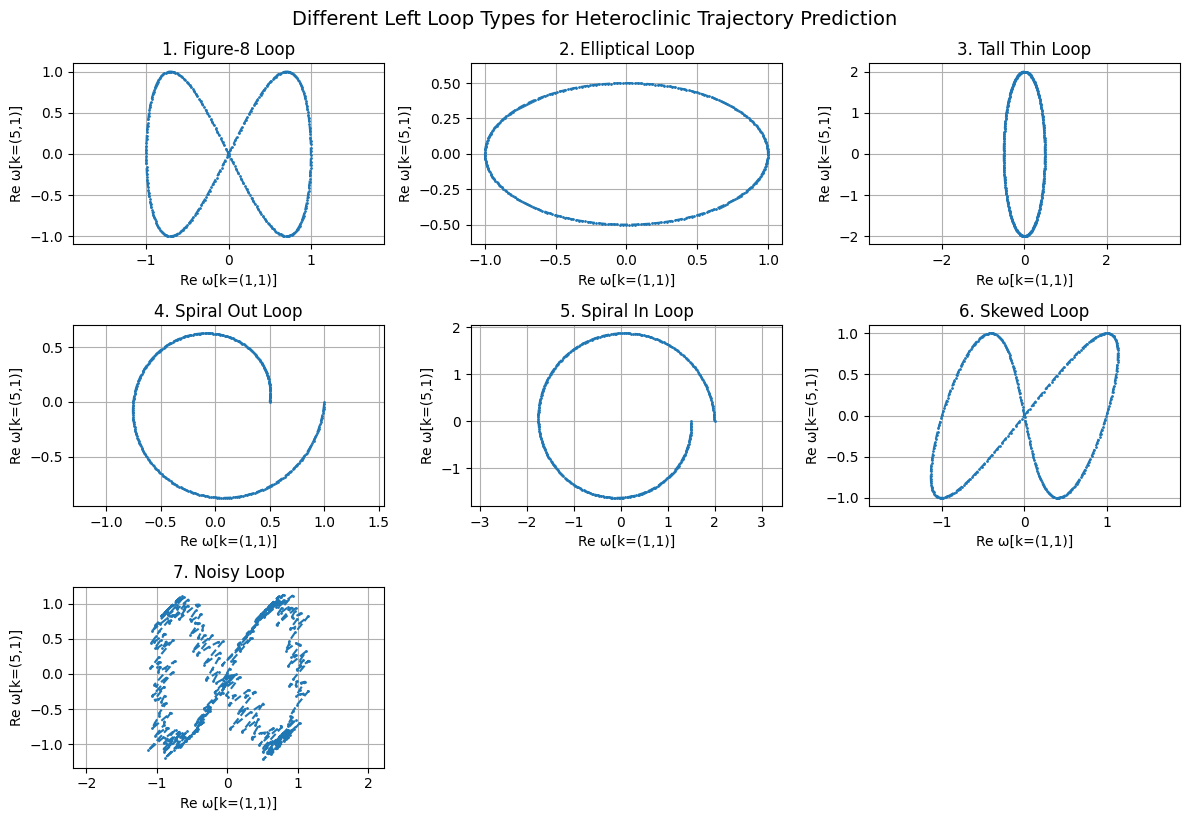

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Define different loop generators
def figure8_loop(t):
    return np.sin(t), np.sin(2*t)

def elliptical_loop(t):
    return np.cos(t), 0.5 * np.sin(t)

def tall_thin_loop(t):
    return 0.5 * np.cos(t), 2 * np.sin(t)

def spiral_out_loop(t):
    r = 0.5 + t / (4 * np.pi)
    return r * np.cos(t), r * np.sin(t)

def spiral_in_loop(t):
    r = 2 - t / (4 * np.pi)
    return r * np.cos(t), r * np.sin(t)

def skewed_loop(t):
    return np.sin(t) + 0.3 * np.sin(2*t), np.sin(2*t)

def noisy_loop(t):
    x = np.sin(t)
    y = np.sin(2*t)
    noise = 0.1 * np.random.randn(*x.shape)
    return x + noise, y + noise

# Time base
t = np.linspace(0, 2*np.pi, 300)

# Loop definitions
loop_funcs = {
    "1. Figure-8 Loop": figure8_loop,
    "2. Elliptical Loop": elliptical_loop,
    "3. Tall Thin Loop": tall_thin_loop,
    "4. Spiral Out Loop": spiral_out_loop,
    "5. Spiral In Loop": spiral_in_loop,
    "6. Skewed Loop": skewed_loop,
    "7. Noisy Loop": noisy_loop,
}

# Plotting
plt.figure(figsize=(12, 8))
for i, (label, func) in enumerate(loop_funcs.items(), 1):
    x, y = func(t)
    plt.subplot(3, 3, i)
    plt.plot(x, y, linestyle='--', marker='.', markersize=2)
    plt.title(label)
    plt.xlabel("Re ω[k=(1,1)]")
    plt.ylabel("Re ω[k=(5,1)]")
    plt.grid(True)
    plt.axis('equal')

plt.tight_layout()
plt.suptitle("Different Left Loop Types for Heteroclinic Trajectory Prediction", fontsize=14, y=1.02)
plt.show()


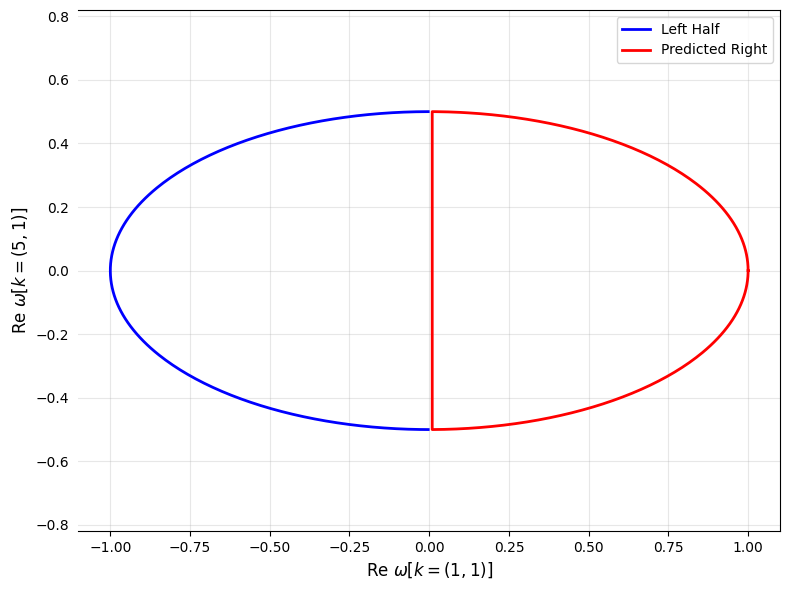

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn

# 1. Data Generation - Clean Elliptical Loops
def generate_clean_loops(num_loops=20, points=500):
    t = np.linspace(0, 2*np.pi, points)
    return np.vstack([np.column_stack((np.cos(t), 0.5*np.sin(t))) for _ in range(num_loops)])

data = generate_clean_loops()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# 2. Split into Clean Left/Right Halves
LOOP_POINTS = 500
num_loops = len(data_scaled) // LOOP_POINTS

X_left, Y_right = [], []
for i in range(num_loops):
    loop = data_scaled[i*LOOP_POINTS:(i+1)*LOOP_POINTS]
    left_mask = loop[:,0] <= 0
    right_mask = loop[:,0] >= 0
    X_left.append(loop[left_mask][:LOOP_POINTS//2])
    Y_right.append(loop[right_mask][:LOOP_POINTS//2])

# 3. Simplified Predictor Model
class CleanPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.LSTM(2, 128, num_layers=2, batch_first=True)
        self.decoder = nn.Linear(128, LOOP_POINTS//2*2)
        
    def forward(self, x):
        _, (hidden, _) = self.encoder(x)
        return self.decoder(hidden[-1]).view(-1, LOOP_POINTS//2, 2)

# 4. Training
model = CleanPredictor()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
X_train = torch.FloatTensor(np.array(X_left[:int(0.85*len(X_left))]))
Y_train = torch.FloatTensor(np.array(Y_right[:int(0.85*len(Y_right))]))

for epoch in range(200):
    model.train()
    for xb, yb in DataLoader(TensorDataset(X_train, Y_train), batch_size=16, shuffle=True):
        optimizer.zero_grad()
        loss = nn.MSELoss()(model(xb), yb)
        loss.backward()
        optimizer.step()

# 5. Clean Visualization (keeping grid but removing y-axis line)
def show_clean_prediction(idx=0):
    model.eval()
    with torch.no_grad():
        left = X_left[-1]  # Use last loop as example
        pred_right = model(torch.FloatTensor(left).unsqueeze(0)).squeeze(0).numpy()
        
        # Inverse transform
        left_orig = scaler.inverse_transform(left)
        right_orig = scaler.inverse_transform(pred_right)
        
        plt.figure(figsize=(8, 6))
        ax = plt.gca()
        
        # Plot halves
        plt.plot(left_orig[:,0], left_orig[:,1], 'b-', linewidth=2, label='Left Half')
        plt.plot(right_orig[:,0], right_orig[:,1], 'r-', linewidth=2, label='Predicted Right')
        
        # Remove only the y-axis line but keep everything else
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('none')  # Hide y-axis ticks but keep x-axis
        
        # Keep grid and other elements
        plt.xlabel(r'Re $\omega[k=(1,1)]$', fontsize=12)
        plt.ylabel(r'Re $\omega[k=(5,1)]$', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

show_clean_prediction()

Choose prediction mode:
1. Hybrid BiLSTM + SINDy (predict right loop from left loop)
2. Elliptical Half Predictor (predict right half from left half)


Enter choice (1 or 2):  1


Training BiLSTM...
Epoch 0, Loss = 1.005066
Epoch 50, Loss = 0.253643
Epoch 100, Loss = 0.005708
Epoch 150, Loss = 0.002542
Epoch 200, Loss = 0.001333

Learned SINDy Equations:
(x0)' = 0.033 1 + 0.064 x0 + 0.283 x1 + -0.053 x0^2 + -0.130 x0 x1 + -0.107 x1^2 + -0.051 x0^3 + -0.228 x0^2 x1 + -0.447 x0 x1^2 + -0.171 x1^3 + 0.007 x0^4 + 0.064 x0^3 x1 + 0.075 x0^2 x1^2 + 0.055 x0 x1^3 + 0.052 x1^4 + 0.001 x0^5 + 0.067 x0^4 x1 + 0.116 x0^3 x1^2 + 0.029 x0^2 x1^3 + 0.228 x0 x1^4 + 0.052 x1^5
(x1)' = 0.214 1 + 0.852 x0 + 0.160 x1 + -0.830 x0^2 + -0.083 x0 x1 + -0.166 x1^2 + -1.120 x0^3 + -0.022 x0^2 x1 + -0.739 x0 x1^2 + -0.245 x1^3 + 0.357 x0^4 + 0.224 x0^2 x1^2 + 0.111 x0 x1^3 + 0.065 x1^4 + 0.324 x0^5 + -0.044 x0^4 x1 + 0.320 x0^3 x1^2 + 0.136 x0^2 x1^3 + 0.285 x0 x1^4 + 0.042 x1^5


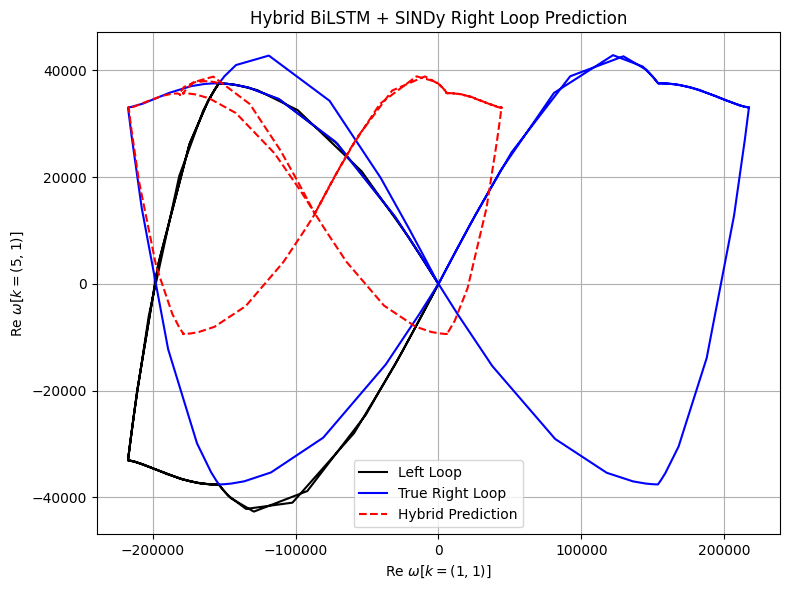

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import pysindy as ps

def main():
    # Let user choose prediction mode
    print("Choose prediction mode:")
    print("1. Hybrid BiLSTM + SINDy (predict right loop from left loop)")
    print("2. Elliptical Half Predictor (predict right half from left half)")
    choice = input("Enter choice (1 or 2): ").strip()
    
    if choice == '1':
        run_hybrid_model()
    elif choice == '2':
        run_elliptical_predictor()
    else:
        print("Invalid choice. Running hybrid model by default.")
        run_hybrid_model()

def run_hybrid_model():
    # ================================================
    # 1. Load and Normalize Data
    # ================================================
    data = np.loadtxt(r"C:\Users\lenovo\Downloads\projection.dat")[:10000]  # (10000, 2)
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # ================================================
    # 2. Extract Loop Pairs
    # ================================================
    LOOP_LEN = 500
    NUM_LOOPS = len(data_scaled) // (2 * LOOP_LEN)
    X_loops, Y_loops = [], []

    for i in range(NUM_LOOPS):
        start = i * 2 * LOOP_LEN
        left = data_scaled[start : start + LOOP_LEN]
        right = data_scaled[start + LOOP_LEN : start + 2 * LOOP_LEN]
        X_loops.append(left)
        Y_loops.append(right)

    X = np.array(X_loops)
    Y = np.array(Y_loops)

    # ================================================
    # 3. Train-Test Split
    # ================================================
    split = int(0.85 * len(X))
    X_train, Y_train = torch.FloatTensor(X[:split]), torch.FloatTensor(Y[:split])
    X_test, Y_test = torch.FloatTensor(X[split:]), torch.FloatTensor(Y[split:])
    train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=16, shuffle=True)

    # ================================================
    # 4. Train BiLSTM Model
    # ================================================
    class BiLSTM(nn.Module):
        def __init__(self, input_size=2, hidden_size=64, loop_len=LOOP_LEN):
            super().__init__()
            self.encoder = nn.LSTM(input_size, hidden_size, num_layers=2, bidirectional=True, batch_first=True)
            self.decoder = nn.Sequential(
                nn.Linear(hidden_size * 2, 128),
                nn.ReLU(),
                nn.Linear(128, loop_len * input_size)
            )
            self.loop_len = loop_len
            self.input_size = input_size

        def forward(self, x):
            _, (h, _) = self.encoder(x)
            z = torch.cat([h[-2], h[-1]], dim=1)
            out = self.decoder(z)
            return out.view(-1, self.loop_len, self.input_size)

    model = BiLSTM()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    print("Training BiLSTM...")
    for epoch in range(250):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss = {total_loss / len(train_loader):.6f}")

    # ================================================
    # 5. Use PySINDy to Extract Equations
    # ================================================
    diff = ps.SmoothedFiniteDifference()
    lib = ps.PolynomialLibrary(degree=5)
    opt = ps.STLSQ(threshold=1e-3, alpha=1e-6)
    sindy_model = ps.SINDy(optimizer=opt, differentiation_method=diff, feature_library=lib)
    sindy_model.fit(data_scaled, t=1.0)
    print("\nLearned SINDy Equations:")
    sindy_model.print()

    # ================================================
    # 6. Hybrid Prediction
    # ================================================
    model.eval()
    idx = 0  # First test loop
    left_test = X_test[idx].unsqueeze(0)
    pred_lstm = model(left_test).squeeze(0).detach().numpy()

    # Simulate from last left point using SINDy
    t_sim = np.arange(LOOP_LEN)
    init_state = left_test[0, -1].numpy()
    pred_sindy = sindy_model.simulate(init_state, t_sim)

    # Combine: average or blend (simple average here)
    pred_hybrid = 0.6 * pred_lstm + 0.4 * pred_sindy

    # Inverse transform to original scale
    left_orig = scaler.inverse_transform(left_test.squeeze(0).numpy())
    pred_orig = scaler.inverse_transform(pred_hybrid)
    true_orig = scaler.inverse_transform(Y_test[idx].numpy())

    # ================================================
    # 7. Plot Comparison
    # ================================================
    plt.figure(figsize=(8,6))
    plt.plot(left_orig[:,0], left_orig[:,1], 'k-', label='Left Loop')
    plt.plot(true_orig[:,0], true_orig[:,1], 'b-', label='True Right Loop')
    plt.plot(pred_orig[:,0], pred_orig[:,1], 'r--', label='Hybrid Prediction')
    plt.xlabel(r'Re $\omega[k=(1,1)]$')
    plt.ylabel(r'Re $\omega[k=(5,1)]$')
    plt.grid(True)
    plt.legend()
    plt.title("Hybrid BiLSTM + SINDy Right Loop Prediction")
    plt.tight_layout()
    plt.show()

def run_elliptical_predictor():
    # 1. Data Generation - Clean Elliptical Loops
    def generate_clean_loops(num_loops=20, points=500):
        t = np.linspace(0, 2*np.pi, points)
        return np.vstack([np.column_stack((np.cos(t), 0.5*np.sin(t))) for _ in range(num_loops)])

    data = generate_clean_loops()
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # 2. Split into Clean Left/Right Halves
    LOOP_POINTS = 500
    num_loops = len(data_scaled) // LOOP_POINTS

    X_left, Y_right = [], []
    for i in range(num_loops):
        loop = data_scaled[i*LOOP_POINTS:(i+1)*LOOP_POINTS]
        left_mask = loop[:,0] <= 0
        right_mask = loop[:,0] >= 0
        X_left.append(loop[left_mask][:LOOP_POINTS//2])
        Y_right.append(loop[right_mask][:LOOP_POINTS//2])

    # 3. Simplified Predictor Model
    class CleanPredictor(nn.Module):
        def __init__(self):
            super().__init__()
            self.encoder = nn.LSTM(2, 128, num_layers=2, batch_first=True)
            self.decoder = nn.Linear(128, LOOP_POINTS//2*2)
            
        def forward(self, x):
            _, (hidden, _) = self.encoder(x)
            return self.decoder(hidden[-1]).view(-1, LOOP_POINTS//2, 2)

    # 4. Training
    model = CleanPredictor()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    X_train = torch.FloatTensor(np.array(X_left[:int(0.85*len(X_left))]))
    Y_train = torch.FloatTensor(np.array(Y_right[:int(0.85*len(Y_right))]))

    for epoch in range(200):
        model.train()
        for xb, yb in DataLoader(TensorDataset(X_train, Y_train), batch_size=16, shuffle=True):
            optimizer.zero_grad()
            loss = nn.MSELoss()(model(xb), yb)
            loss.backward()
            optimizer.step()

    # 5. Clean Visualization (keeping grid but removing y-axis line)
    def show_clean_prediction(idx=0):
        model.eval()
        with torch.no_grad():
            left = X_left[-1]  # Use last loop as example
            pred_right = model(torch.FloatTensor(left).unsqueeze(0)).squeeze(0).numpy()
            
            # Inverse transform
            left_orig = scaler.inverse_transform(left)
            right_orig = scaler.inverse_transform(pred_right)
            
            plt.figure(figsize=(8, 6))
            ax = plt.gca()
            
            # Plot halves
            plt.plot(left_orig[:,0], left_orig[:,1], 'b-', linewidth=2, label='Left Half')
            plt.plot(right_orig[:,0], right_orig[:,1], 'r-', linewidth=2, label='Predicted Right')
            
            # Remove only the y-axis line but keep everything else
            ax.spines['left'].set_visible(False)
            ax.yaxis.set_ticks_position('none')  # Hide y-axis ticks but keep x-axis
            
            # Keep grid and other elements
            plt.xlabel(r'Re $\omega[k=(1,1)]$', fontsize=12)
            plt.ylabel(r'Re $\omega[k=(5,1)]$', fontsize=12)
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.axis('equal')
            plt.tight_layout()
            plt.show()

    show_clean_prediction()

if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

def run_bilstm_autoregressive():
    # ================================================
    # 1. Load and Normalize Data
    # ================================================
    data = np.loadtxt(r"C:\Users\lenovo\Downloads\projection.dat")[:10000]
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    LOOP_POINTS = 500
    NUM_LOOPS = len(data_scaled) // LOOP_POINTS
    X_left, Y_right = [], []

    for i in range(NUM_LOOPS):
        loop = data_scaled[i * LOOP_POINTS : (i + 1) * LOOP_POINTS]
        X_left.append(loop[:LOOP_POINTS // 2])
        Y_right.append(loop[LOOP_POINTS // 2:])

    X = np.array(X_left)  # (N, 250, 2)
    Y = np.array(Y_right) # (N, 250, 2)

    # ================================================
    # 2. Prepare Torch Data
    # ================================================
    split = int(0.85 * len(X))
    X_train = torch.FloatTensor(X[:split])
    Y_train = torch.FloatTensor(Y[:split])
    X_test = torch.FloatTensor(X[split:])
    Y_test = torch.FloatTensor(Y[split:])
    train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=16, shuffle=True)

    # ================================================
    # 3. Define Model: BiLSTM Encoder + LSTM Decoder
    # ================================================
    class Seq2Seq(nn.Module):
        def __init__(self, input_size=2, hidden_size=128, output_size=2, seq_len=250):
            super().__init__()
            self.hidden_size = hidden_size
            self.seq_len = seq_len
            self.encoder = nn.LSTM(input_size, hidden_size, num_layers=2, bidirectional=True, batch_first=True)
            self.decoder = nn.LSTM(output_size, hidden_size*2, num_layers=1, batch_first=True)
            self.fc = nn.Linear(hidden_size*2, output_size)

        def forward(self, src, tgt=None, teacher_forcing_ratio=0.5):
            batch_size = src.size(0)
            device = src.device
            _, (hidden, _) = self.encoder(src)
            # Concatenate last layer from both directions
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1).unsqueeze(0)

            # Decoder init input: first target (or zero if not available)
            decoder_input = torch.zeros(batch_size, 1, 2).to(device)
            outputs = []

            h, c = hidden.repeat(1, 1, 1), torch.zeros_like(hidden)

            for t in range(self.seq_len):
                out, (h, c) = self.decoder(decoder_input, (h, c))
                pred = self.fc(out.squeeze(1))
                outputs.append(pred.unsqueeze(1))

                # Teacher forcing
                if tgt is not None and np.random.rand() < teacher_forcing_ratio:
                    decoder_input = tgt[:, t].unsqueeze(1)
                else:
                    decoder_input = pred.unsqueeze(1)

            return torch.cat(outputs, dim=1)

    # ================================================
    # 4. Train Model
    # ================================================
    model = Seq2Seq().to("cpu")
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    print("Training BiLSTM → LSTM Decoder (Autoregressive)...")
    for epoch in range(200):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb, yb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 25 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss / len(train_loader):.6f}")

    # ================================================
    # 5. Evaluate and Visualize
    # ================================================
    def visualize_prediction(index=-1):
        model.eval()
        with torch.no_grad():
            left = X_test[index].unsqueeze(0)
            true_right = Y_test[index]
            pred_right = model(left).squeeze(0).cpu()

            # Inverse transform
            left_orig = scaler.inverse_transform(left.squeeze(0))
            true_orig = scaler.inverse_transform(true_right)
            pred_orig = scaler.inverse_transform(pred_right)

            plt.figure(figsize=(8, 6))
            plt.plot(left_orig[:, 0], left_orig[:, 1], 'b-', label='Left Half')
            plt.plot(true_orig[:, 0], true_orig[:, 1], 'g--', label='True Right Half')
            plt.plot(pred_orig[:, 0], pred_orig[:, 1], 'r-', label='Predicted Right Half')
            plt.xlabel(r'Re $\omega[k=(1,1)]$')
            plt.ylabel(r'Re $\omega[k=(5,1)]$')
            plt.grid(True)
            plt.axis('equal')
            plt.legend()
            plt.title("Right Half Prediction from Left Half (Autoregressive BiLSTM)")
            plt.tight_layout()
            plt.show()

    visualize_prediction()

if __name__ == "__main__":
    run_bilstm_autoregressive()


Training BiLSTM → LSTM Decoder (Autoregressive)...
Epoch 0, Loss: 0.967882
Epoch 25, Loss: 0.117000
Epoch 50, Loss: 0.073198
Epoch 75, Loss: 0.064702
Epoch 100, Loss: 0.050986
Epoch 125, Loss: 0.050792
Epoch 150, Loss: 0.052348
